In [1]:
import pandas as pd
from pyproj import Transformer

# === Step 1: Load raw NHS postcode directory file ===
lookup_path = "../data/raw/NHSPD_Online_Latest_Centroids_-4877554260104560705.csv"  # adjust as needed
df = pd.read_csv(lookup_path)

# === Step 2: Select and rename key columns ===
cols_to_keep = ['PCDS', 'OSEAST1M', 'OSNRTH1M', 'LSOA21', 'MSOA21', 'OA21', 'ICB', 'OSLAUA']
df = df[cols_to_keep].dropna(subset=['OSEAST1M', 'OSNRTH1M'])

# === Step 3: Ensure coordinates are numeric ===
df['OSEAST1M'] = pd.to_numeric(df['OSEAST1M'], errors='coerce')
df['OSNRTH1M'] = pd.to_numeric(df['OSNRTH1M'], errors='coerce')
df = df.dropna(subset=['OSEAST1M', 'OSNRTH1M'])

# === Step 4: Convert British National Grid to WGS84 lat/lon ===
transformer = Transformer.from_crs("epsg:27700", "epsg:4326")  # BNG → WGS84
df['latitude'], df['longitude'] = zip(*df.apply(
    lambda row: transformer.transform(row['OSEAST1M'], row['OSNRTH1M']), axis=1))

# === Step 5: Clean postcode for joins ===
df['postcode'] = df['PCDS'].astype(str).str.strip().str.replace(" ", "").str.upper()
df.drop(columns='PCDS', inplace=True)

# === Final Output: Enriched postcode lookup dataframe ===
df = df[['postcode', 'latitude', 'longitude', 'LSOA21', 'MSOA21', 'OA21', 'ICB', 'OSLAUA']]
df.rename(columns={
    'LSOA21': 'lsoa21cd',
    'MSOA21': 'msoa21cd',
    'OA21': 'oa21cd',
    'ICB': 'icb_code',
    'OSLAUA': 'local_authority'
}, inplace=True)

# === Optional: Save output ===
df.to_csv("../data/processed/nhs_postcode_centroids_enriched.csv", index=False)

print("Postcode lookup enriched with lat/lon and LSOA21.")
print(df.head())


Postcode lookup enriched with lat/lon and LSOA21.
  postcode   latitude  longitude   lsoa21cd   msoa21cd     oa21cd icb_code  \
0  SO454WW  50.867505  -1.399957  E01023008  E02004787  E00116921      QRL   
1  DT102FF  50.872655  -2.365152  E01020448  E02004262  E00103635      QVV   
2  BS405EZ  51.346684  -2.781708  E01014748  E02003088  E00074496      QUY   
3   BS70SF  51.501152  -2.579009  E01014909  E02003107  E00075336      QUY   
4  CF230DE  51.502014  -3.117372  W01001885  W02000377  W00009676      W92   

  local_authority  
0       E07000091  
1       E06000059  
2       E06000024  
3       E06000025  
4       W06000015  


In [7]:
import pandas as pd
from pathlib import Path

# Paths
input_dir = Path("../data/processed/Health Infrastructure")
lookup_path = Path("../data/processed/nhs_postcode_centroids_enriched.csv")
output_dir = input_dir / "enriched"
missing_dir = input_dir / "missing_postcodes"

# Create output folders
output_dir.mkdir(parents=True, exist_ok=True)
missing_dir.mkdir(parents=True, exist_ok=True)

# Load lookup table
lookup = pd.read_csv(lookup_path, dtype=str)
lookup['postcode_clean'] = lookup['postcode'].str.strip().str.upper().str.replace(" ", "")

# Facility files to process
facility_files = sorted(input_dir.glob("*.csv"))
summary_rows = []

# Process each file
for file in facility_files:
    print(f"\nProcessing: {file.name}")
    try:
        df = pd.read_csv(file, dtype=str)

        if "Postcode" not in df.columns:
            print("⚠Skipped: No 'Postcode' column.")
            continue

        # Clean postcode
        df["postcode_clean"] = df["Postcode"].astype(str).str.strip().str.upper().str.replace(" ", "")

        # Enrich with spatial lookup
        merged = pd.merge(df, lookup, on="postcode_clean", how="left")

        # Track match rates
        total = len(merged)
        matched = merged['latitude'].notna().sum()
        unmatched_df = merged[merged['latitude'].isna()]

        print(f"Matched {matched} of {total} rows ({matched / total:.1%})")

        # Save enriched
        enriched_file = output_dir / f"{file.stem}_enriched.csv"
        merged.to_csv(enriched_file, index=False)
        print(f"💾 Enriched saved: {enriched_file.name}")

        # Save unmatched to separate folder
        if not unmatched_df.empty:
            missing_file = missing_dir / f"{file.stem}_missing.csv"
            unmatched_df.to_csv(missing_file, index=False)
            print(f"Unmatched saved: {missing_file.name}")

        # Summary logging
        summary_rows.append({
            "Filename": file.name,
            "Total Rows": total,
            "Matched Postcodes": matched,
            "Unmatched Postcodes": total - matched,
            "Match Rate": f"{(matched / total):.1%}"
        })

    except Exception as e:
        print(f"Error processing {file.name}: {e}")
        summary_rows.append({
            "Filename": file.name,
            "Total Rows": "ERROR",
            "Matched Postcodes": "",
            "Unmatched Postcodes": "",
            "Match Rate": f"Error: {e}"
        })

# Output summary table
summary_df = pd.DataFrame(summary_rows)
display(summary_df)



Processing: NHS_SW_ Community_Diagnostic_Centres.csv
Matched 23 of 24 rows (95.8%)
💾 Enriched saved: NHS_SW_ Community_Diagnostic_Centres_enriched.csv
Unmatched saved: NHS_SW_ Community_Diagnostic_Centres_missing.csv

Processing: NHS_SW_ GP_Practices_and_Polyclinics.csv
Matched 862 of 963 rows (89.5%)
💾 Enriched saved: NHS_SW_ GP_Practices_and_Polyclinics_enriched.csv
Unmatched saved: NHS_SW_ GP_Practices_and_Polyclinics_missing.csv

Processing: NHS_SW_Acute_Hospitals.csv
Matched 21 of 264 rows (8.0%)
💾 Enriched saved: NHS_SW_Acute_Hospitals_enriched.csv
Unmatched saved: NHS_SW_Acute_Hospitals_missing.csv

Processing: NHS_SW_Ambulance_Stations.csv
Matched 81 of 87 rows (93.1%)
💾 Enriched saved: NHS_SW_Ambulance_Stations_enriched.csv
Unmatched saved: NHS_SW_Ambulance_Stations_missing.csv

Processing: NHS_SW_Community_Hospitals.csv
Matched 85 of 92 rows (92.4%)
💾 Enriched saved: NHS_SW_Community_Hospitals_enriched.csv
Unmatched saved: NHS_SW_Community_Hospitals_missing.csv

Processing: 

,Filename,Total Rows,Matched Postcodes,Unmatched Postcodes,Match Rate
0,NHS_SW_ Community_Diagnostic_Centres.csv,24,23,1,95.8%
1,NHS_SW_ GP_Practices_and_Polyclinics.csv,963,862,101,89.5%
2,NHS_SW_Acute_Hospitals.csv,264,21,243,8.0%
3,NHS_SW_Ambulance_Stations.csv,87,81,6,93.1%
4,NHS_SW_Community_Hospitals.csv,92,85,7,92.4%
5,NHS_SW_Community_and_Outreach_Facilities.csv,278,256,22,92.1%
6,NHS_SW_Specialist_Hospitals.csv,23,20,3,87.0%


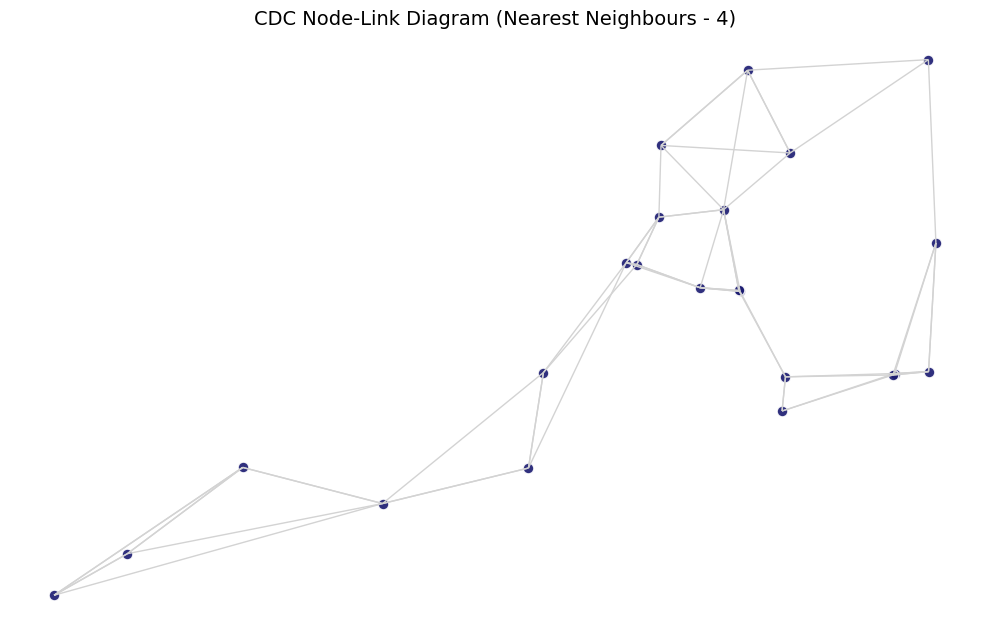

In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load CDC data
file_path = "../data/processed/Health Infrastructure/enriched/NHS_SW_ Community_Diagnostic_Centres_enriched.csv"
df = pd.read_csv(file_path)

# Clean coordinates
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df = df.dropna(subset=['latitude', 'longitude'])

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"
)

# Project to EPSG:3857 for accurate distance and plotting
gdf = gdf.to_crs("EPSG:3857")

# Build nearest neighbour lines (e.g., k=2)
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
nbrs = NearestNeighbors(n_neighbors=4).fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Generate lines between each node and its nearest neighbour (excluding self-loop)
lines = []
for i, neighbors in enumerate(indices):
    for j in neighbors[1:]:  # skip self
        lines.append(LineString([gdf.geometry.iloc[i], gdf.geometry.iloc[j]]))

# Build GeoDataFrame of edges
edges = gpd.GeoDataFrame(geometry=lines, crs=gdf.crs)

# Plotting
fig, ax = plt.subplots(figsize=(10, 12))
edges.plot(ax=ax, color="lightgray", linewidth=1)
gdf.plot(ax=ax, color="midnightblue", markersize=60, alpha=0.9, edgecolor='white')

ax.set_title("CDC Node-Link Diagram (Nearest Neighbours - 4)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()
